In [3]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# data was already split this is only for calculating the new pca metric
ens_data = pd.read_json('/home/alevink/capstone/ens_data.json.gz')
all_data = pd.read_json('/home/alevink/capstone/dataset_11_29_22.json.gz')

In [5]:
try:
    ens_data.drop('pca_metric', axis=1, inplace=True)
except KeyError:
    pass

In [6]:
ens_data.columns

Index(['vid_id', 'chan_query', 'chan_id', 'chan_name', 'chan_viewcount',
       'chan_subcount', 'chan_start_dt', 'chan_thumb', 'chan_vidcount',
       'vid_name', 'vid_publish_dt', 'vid_thumb', 'vid_duration',
       'vid_caption', 'vid_viewcount', 'vid_likecount', 'vid_commentcount',
       'description', 'duration', 'age_limit', 'categories', 'tags', 'is_live',
       'width', 'height', 'fps', 'vcodec', 'vbr', 'acodec', 'abr',
       'thumb_name', 'subtitles', 'thumb_width', 'thumb_height'],
      dtype='object')

In [7]:
all_data.columns

Index(['vid_id', 'chan_query', 'chan_id', 'chan_name', 'chan_viewcount',
       'chan_subcount', 'chan_start_dt', 'chan_thumb', 'chan_vidcount',
       'vid_name', 'vid_publish_dt', 'vid_thumb', 'vid_duration',
       'vid_caption', 'vid_viewcount', 'vid_likecount', 'vid_commentcount',
       'description', 'duration', 'age_limit', 'categories', 'tags', 'is_live',
       'width', 'height', 'fps', 'vcodec', 'vbr', 'acodec', 'abr',
       'thumb_name', 'subtitles', 'thumb_width', 'thumb_height'],
      dtype='object')

In [8]:
all_data.shape, ens_data.shape

((1120959, 34), (71233, 34))

In [9]:
all_data = all_data.dropna(subset=['vid_viewcount', 'vid_likecount', 'vid_commentcount'])

In [10]:
all_data.shape

(1120950, 34)

In [11]:
def make_new_metric(df):
    df_ = df.copy()
    df_['vid_viewcount'] = df_['vid_viewcount'].astype('int64')
    df_['vid_likecount'] = df_['vid_likecount'].astype('int64')
    df_['vid_commentcount'] = df_['vid_commentcount'].astype('int64')
    
    df_ = np.log(df_[['vid_viewcount', 'vid_likecount', 'vid_commentcount']] + 1)
    pca = PCA(n_components=1)
    score = pca.fit_transform(df_)
    return score

<AxesSubplot:>

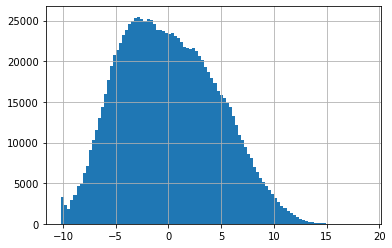

In [12]:
# final model will predict this metric
all_data['pca_metric'] = make_new_metric(all_data)
all_data['pca_metric'].hist(bins=100)

<AxesSubplot:>

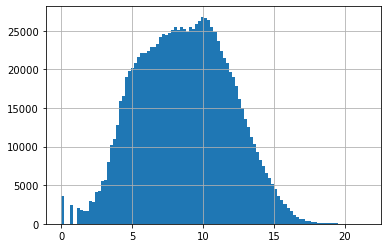

In [13]:
# cnn will predict the log video view counts
np.log(all_data['vid_viewcount']+1).hist(bins=100)

In [14]:
display(all_data['pca_metric'].isnull().sum())
metric = all_data[['vid_id', 'pca_metric']]

0

In [16]:
ens_data = ens_data.merge(metric, on='vid_id')

In [17]:
ens_data.to_json('/home/alevink/capstone/ens_data.json.gz')

In [15]:
# to train feature engenering transformer using the notebook yt_features.ipynb
subs = all_data.dropna(subset=['subtitles',])
subs.shape

(546829, 35)

In [16]:
subs = subs[subs['subtitles'] != '---missing---']
subs.shape

(368847, 35)

In [17]:
# to avoid data leakage the transformer will not be trained on any data for the final model
subs = subs[~subs['vid_id'].isin(ens_data['vid_id'])]
subs.shape

(297614, 35)

In [18]:
subs.to_json('/home/alevink/capstone/for_subs_transformer.json.gz')